
<center><h1>ESG creates Intangible Value</h1></center>
<hr>
<center><h2> This report analyzes the correlation between ESG and Intangible value</h2></center>
<hr>



### 1. Import of relevant data 

In [1]:
# import the relevant packages
from scipy.interpolate import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Set matplotlib inline
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
!pip install linearmodels
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
!pip install nb2xls

### Import and read ESGdata.csv

In [2]:
df = pd.read_csv('ESGData.csv',encoding = "ISO-8859-1",index_col= [0,1])
print(df.head(3))

                                    cusip Ticker  Environment   Social   \
Company                    Year                                           
Agilent Technologies, Inc. 2000  00846U10      A             0        1   
                           2001  00846U10      A             0        1   
                           2002  00846U10      A             0        7   

                                 Governance   SumofESG   New SUMofESG  \
Company                    Year                                         
Agilent Technologies, Inc. 2000           -2          5            -1   
                           2001           -2         -4            -1   
                           2002            0          0             7   

                                      P/B       ROA  Leverage      SG&A  \
Company                    Year                                           
Agilent Technologies, Inc. 2000  3.993307  0.197281  0.375074  0.770022   
                           2001  

In [3]:
print(df.shape)

(26314, 16)


### 2. Data cleansIng  

In [4]:
def winsorize_series(s):
    q = s.quantile([0.01, 0.99])
    if isinstance(q, pd.Series) and len(q) == 2:
        s[s < q.iloc[0]] = q.iloc[0]
        s[s > q.iloc[1]] = q.iloc[1]
    return s

def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

In [5]:
display(df[0:3])
print(df.shape)

cusip Ticker  Environment   Social   \
Company                    Year                                           
Agilent Technologies, Inc. 2000  00846U10      A             0        1   
                           2001  00846U10      A             0        1   
                           2002  00846U10      A             0        7   

                                 Governance   SumofESG   New SUMofESG  \
Company                    Year                                         
Agilent Technologies, Inc. 2000           -2          5            -1   
                           2001           -2         -4            -1   
                           2002            0          0             7   

                                      P/B       ROA  Leverage      SG&A  \
Company                    Year                                           
Agilent Technologies, Inc. 2000  3.993307  0.197281  0.375074  0.770022   
                           2001  1.814184 -0.065282  0.291385  0.458042   
                           2002  1.387778 -0.141873  0.435938  0.458177   

                                      ROE       R&D     CAPEX  Intangible  \
Company                    Year                                             
Agilent Technologies, Inc. 2000  0.203989  0.231080  0.151359    0.102314   
                           2001 -0.097190  0.160119  0.104570    0.127003   
                           2002 -0.244867  0.146381  0.037691    0.085775   

                                  Revenue  
Company                    Year            
Agilent Technologies, Inc. 2000  1.978876  
                           2001  0.996558  
                           2002  0.752567

(26314, 16)


In [6]:
# remove p/b = 0
df = df.loc[~((df['P/B'] == 0))]
print(df.shape)
# remove White spaces
df.columns = df.columns.str.strip()
print(df.shape)
# remove NA values
df['P/B'].dropna()
df['SumofESG'].dropna()

(22533, 16)
(22533, 16)


Company                     Year
Agilent Technologies, Inc.  2000    5
                            2001   -4
                            2002    0
                            2003   -2
                            2004   -1
                                   ..
Sealy Corporation           2007   -3
                            2008   -2
                            2009    1
                            2010   -3
                            2011   -3
Name: SumofESG, Length: 22533, dtype: int64

In [7]:
df.describe()

,Environment,Social,Governance,SumofESG,New SUMofESG,P/B,ROA,Leverage,SG&A,ROE,R&D,CAPEX,Intangible,Revenue
count,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000,22533.000000
mean,0.138153,0.240625,-0.339413,-0.033551,0.039364,3.469425,0.084275,0.792202,0.156754,0.211655,0.020259,0.047244,0.196312,0.887368
std,0.954749,2.064762,0.790897,2.481644,2.710089,63.257508,0.093154,0.492158,0.183421,3.374144,0.049455,0.071583,0.271685,0.868474
min,-5.000000,-9.000000,-5.000000,-12.000000,-12.000000,-1351.686491,-0.762097,0.000000,-0.042283,-265.494845,0.000000,-0.029157,0.000000,-0.048917
25%,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.314011,0.021467,0.477815,0.010055,0.086501,0.000000,0.007326,0.012681,0.293178
50%,0.000000,0.000000,0.000000,0.000000,0.000000,2.023999,0.072849,0.638513,0.097351,0.172228,0.000000,0.028380,0.093544,0.687869
75%,0.000000,1.000000,0.000000,1.000000,1.000000,3.238193,0.128209,0.894208,0.238853,0.283726,0.016762,0.059886,0.303215,1.201398
max,6.000000,15.000000,2.000000,20.000000,20.000000,6273.818908,1.216186,7.312602,1.836054,233.176471,1.792264,1.680478,9.914449,13.490562


### 3. Analyze the data 

In [8]:
# Random effects Estimation Summary (All Data)
exog_vars = ['Environment','Social','Governance','Revenue','SG&A','ROA','ROE','R&D','CAPEX','Leverage','Intangible']
exog = sm.add_constant(df[exog_vars])
endog = df['P/B']
#random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
#print results
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    P/B   R-squared:                        0.1666
Estimator:              RandomEffects   R-squared (Between):             -0.7802
No. Observations:               22533   R-squared (Within):               0.4587
Date:                Fri, Jul 15 2022   R-squared (Overall):             -0.0003
Time:                        17:10:41   Log-likelihood                -1.201e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      409.31
Entities:                        5844   P-value                           0.0000
Avg Obs:                       3.8557   Distribution:                F(11,22521)
Min Obs:                       0.0000                                           
Max Obs:                       19.000   F-statistic (robust):             408.95
                            

In [9]:
# Panel regression summary (All data)
exog_vars = ['Environment','Social','Governance','Revenue','SG&A','ROA','ROE','R&D','CAPEX','Leverage','Intangible']
exog = sm.add_constant(df[exog_vars])
endog = df['P/B']
#fixed Effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    P/B   R-squared:                        0.5803
Estimator:                   PanelOLS   R-squared (Between):             -1.6713
No. Observations:               22533   R-squared (Within):               0.5803
Date:                Fri, Jul 15 2022   R-squared (Overall):             -0.2626
Time:                        17:10:41   Log-likelihood                -1.093e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2150.1
Entities:                        5844   P-value                           0.0000
Avg Obs:                       3.8557   Distribution:                F(11,17108)
Min Obs:                       0.0000                                           
Max Obs:                       19.000   F-statistic (robust):             2150.1
                            

In [10]:
df.rename(columns = {'P/B': 'pricebook','SG&A': 'SGA', 'R&D': 'RD'}, inplace = True)
df.head(1)

,,cusip,Ticker,Environment,Social,Governance,SumofESG,New SUMofESG,pricebook,ROA,Leverage,SGA,ROE,RD,CAPEX,Intangible,Revenue
Company,Year,,,,,,,,,,,,,,,,
"Agilent Technologies, Inc.",2000,00846U10,A,0,1,-2,5,-1,3.993307,0.197281,0.375074,0.770022,0.203989,0.23108,0.151359,0.102314,1.978876


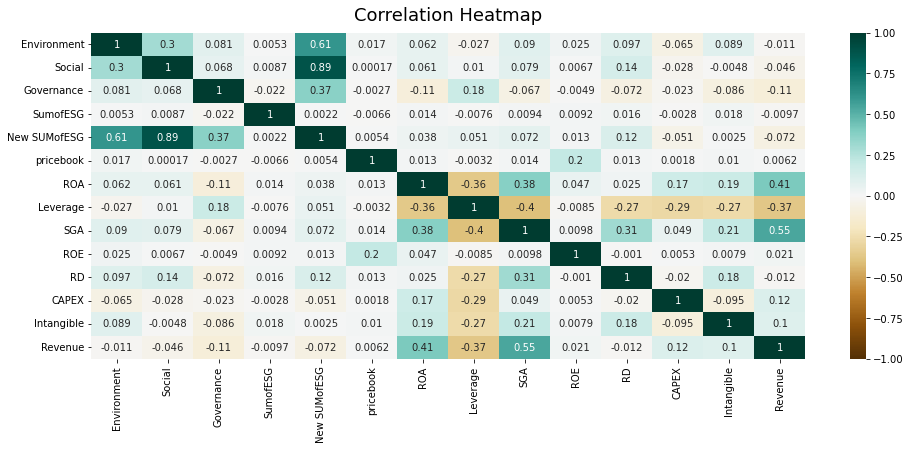

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

In [12]:
df.corr().head(12)

,Environment,Social,Governance,SumofESG,New SUMofESG,pricebook,ROA,Leverage,SGA,ROE,RD,CAPEX,Intangible,Revenue
Environment,1.000000,0.303975,0.080850,0.005347,0.607481,0.017096,0.061595,-0.027423,0.090433,0.025386,0.097446,-0.065300,0.088556,-0.011448
Social,0.303975,1.000000,0.068496,0.008687,0.888958,0.000171,0.061286,0.010436,0.079090,0.006667,0.139477,-0.027902,-0.004795,-0.046176
Governance,0.080850,0.068496,1.000000,-0.021518,0.372503,-0.002659,-0.105419,0.180935,-0.067434,-0.004903,-0.072223,-0.023357,-0.085818,-0.113874
SumofESG,0.005347,0.008687,-0.021518,1.000000,0.002222,-0.006601,0.014326,-0.007597,0.009427,0.009167,0.016104,-0.002800,0.018134,-0.009701
New SUMofESG,0.607481,0.888958,0.372503,0.002222,1.000000,0.005377,0.037627,0.051093,0.072437,0.012592,0.119517,-0.051079,0.002500,-0.072446
pricebook,0.017096,0.000171,-0.002659,-0.006601,0.005377,1.000000,0.013072,-0.003239,0.014010,0.203873,0.012673,0.001757,0.010188,0.006182
ROA,0.061595,0.061286,-0.105419,0.014326,0.037627,0.013072,1.000000,-0.360081,0.377840,0.047044,0.024696,0.169522,0.186668,0.409384
Leverage,-0.027423,0.010436,0.180935,-0.007597,0.051093,-0.003239,-0.360081,1.000000,-0.400534,-0.008536,-0.266200,-0.287845,-0.269934,-0.371902
SGA,0.090433,0.079090,-0.067434,0.009427,0.072437,0.014010,0.377840,-0.400534,1.000000,0.009751,0.310370,0.049000,0.208257,0.546062
ROE,0.025386,0.006667,-0.004903,0.009167,0.012592,0.203873,0.047044,-0.008536,0.009751,1.000000,-0.001002,0.005280,0.007934,0.021140


In [13]:
Dependantlist = ['Environment','Social','Governance','Revenue','SGA','ROA','ROE','RD','CAPEX','Leverage','Intangible']

# list of models
models = []

for resp in Dependantlist:
    formula = resp + " ~ Environment + Social + Governance + Revenue + SGA + ROA + ROE + RD + CAPEX + Leverage + Intangible"
    models.append(sm.OLS.from_formula(formula, data = df).fit())

# each element is your model. For example, you can access its params
models[0].params

Intercept      5.308254e-16
Environment    1.000000e+00
Social        -2.875304e-16
Governance     5.204170e-16
Revenue        2.038300e-16
SGA            4.302114e-16
ROA           -8.743006e-16
ROE           -8.185726e-17
RD             4.857226e-16
CAPEX         -8.326673e-17
Leverage      -1.830133e-16
Intangible    -2.177078e-16
dtype: float64

In [14]:
jupyter nbconvert --to xls Examples/ExcelTest.ipynb

SyntaxError: invalid syntax (2185591697.py, line 1)